# 프로젝트: 퍼스널 컬러 진단 - ResNet101

## 데이터
일반인 웜 490장, 쿨 186장  

## 목표: ResNet101에 퍼스널 컬러 진단 분류하기  

## (1) 라이브러리 및 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
import cv2
import os
import glob
from PIL import Image

In [2]:
# 파일 불러오는 함수
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가
    image_paths = glob.glob(directory_path + '/*.JPG')  # 디렉토리 내의 모든 JPG 파일 경로 찾기

    images = []
    i = 0
    for image_path in image_paths:
        if i == 150:
            break
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)
        i += 1

    return images

In [3]:
# 모든 이미지 불러오기
directory_path = "/aiffel//aiffel/project/first-repository/data/four_seasons/train_warm_1"  # 디렉토리 경로
directory_path2 = "/aiffel/aiffel/project/first-repository/data/four_seasons/train_cool_1/cool_1"  # 디렉토리 경로
images = load_images_from_directory(directory_path)
images2 = load_images_from_directory(directory_path2)

length = len(images)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images, images2), axis=0)
print(len(images))

150
150
300


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## (2) 데이터 전처리

In [4]:
def preprocess_image(image):
    # 이미지 크기 조절
    image = tf.image.resize(image, (224, 224))
    # 이미지를 [0, 1] 범위로 정규화
    image = image / 255.0
    return image

images = np.array([preprocess_image(image) for image in images])
print(images.shape)

(300, 224, 224, 3)


In [5]:
from tensorflow.keras.utils import to_categorical

# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 뒤쪽의 50개의 요소를 1로 변경
labels[length:] = 1

labels = to_categorical(labels, num_classes=2)

# 0이 웜톤 1이 쿨톤
print(len(images))
print(labels.shape)
print(labels)

300
(300, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(images, batch_size=8)

## (3) trian, val 분리하기

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=55)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (210, 224, 224, 3)
y_train:  (210, 2)
x_val:  (90, 224, 224, 3)
y_val:  (90, 2)


In [8]:
# 데이터를 텐서로 변환
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

## (4) 모델 정의 및 컴파일

In [9]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras import optimizers, initializers, regularizers, metrics

# ResNet-50 모델 불러오기
resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(resnet.output) # flatten과 비슷한 역할(각 필터의 평균값을 리턴)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='sigmoid')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=resnet.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
from keras.callbacks import ReduceLROnPlateau

# 콜백 생성
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)

# 모델을 평가 모드로 설정 (학습이 아닌 추론용으로 사용할 때 필요)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## (5) 모델 학습하기

In [11]:
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=30,
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr])

Epoch 1/30
14/14 [==============================] - 61s 576ms/step - loss: 1.0186 - accuracy: 0.5286 - val_loss: 32441.5000 - val_accuracy: 0.4778
Epoch 2/30
14/14 [==============================] - 4s 308ms/step - loss: 0.7737 - accuracy: 0.7810 - val_loss: 8995093504.0000 - val_accuracy: 0.4778
Epoch 3/30
14/14 [==============================] - 4s 310ms/step - loss: 1.2865 - accuracy: 0.7571 - val_loss: 4324953600.0000 - val_accuracy: 0.4778
Epoch 4/30
14/14 [==============================] - 4s 309ms/step - loss: 0.9308 - accuracy: 0.5667 - val_loss: 5074194944.0000 - val_accuracy: 0.4778
Epoch 5/30
14/14 [==============================] - 4s 310ms/step - loss: 0.7647 - accuracy: 0.6000 - val_loss: 1406562.7500 - val_accuracy: 0.4778
Epoch 6/30
14/14 [==============================] - 4s 312ms/step - loss: 0.7805 - accuracy: 0.5524 - val_loss: 442.7173 - val_accuracy: 0.4778
Epoch 7/30
14/14 [==============================] - 4s 311ms/step - loss: 0.7202 - accuracy: 0.6667 - val_lo

## (6) 예측하기

In [12]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
y_val = np.argmax(y_val, axis=1)

In [13]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0
 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1]
[[0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.51513517 0.48361418]
 [0.515

In [14]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.522222


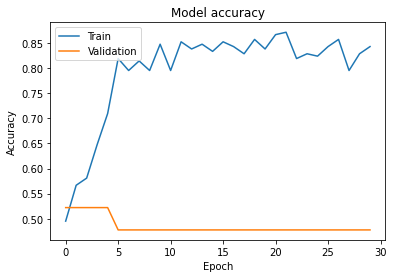

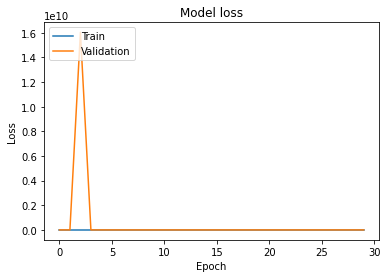

In [26]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## (7) TEST

In [27]:
class_name = ["웜톤", "쿨톤"]

In [ ]:
# test 불러오기 (낱개 버전)
test_path = "/aiffel/aiffel/project/first-repository/data/four_seasons/TEST/박은빈.jpg"
x_test = Image.open(test_path)
x_test = np.array(x_test)
print(x_test.shape)

# 배열의 크기 변환
x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1], 3))
print("변환된 배열 크기:", x_test.shape)

# 전처리(resize, 정규화)
x_test = preprocess_image(x_test)
print(x_test.shape)

# 만약 앱구현과 연결된다면 저장된 모델을 다시 돌릴 필요없이 저장된 최적의 모델을 사용하도록 수정해야함
# test
pred = model.predict(x_test)
pred_class = np.argmax(pred, axis=1)
print("당신은", class_name[int(pred_class)], "입니다~!")
print("웜톤일 확률: ", np.round(pred[:, 0], 3))
print("쿨톤일 확률: ", np.round(pred[:, 1], 3))